# imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from sentinelhub import SHConfig
config = SHConfig()

C:\Users\Harith\anaconda3\envs\sentinal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()

In [16]:
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [17]:
from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Setting area of interest

In [18]:
poly = [[10.030,79.553],[5.886,79.717],[5.930,81.991],[9.986,81.793]]
import numpy as np


In [19]:
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['long','lat'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    i = [1,0]
    output = poly_arr[:,i]
    output = output.tolist()
    return bbox,output

In [20]:
bbox_generated,poly = bbox_cord(poly)
bbox_generated

[79.553, 5.886, 81.991, 10.03]

In [21]:
final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)


In [22]:
resolution =185
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

Image shape at 185 m resolution: (1453, 2476) pixels


In [23]:
#date range
current_date = datetime.today().strftime('%Y-%m-%d')
past_date = datetime.today() - relativedelta(months=12)
past_date = past_date.strftime('%Y-%m-%d')

In [24]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02","B03","B04","B08"],
                units: "DN"
            }],
            output: {
                bands: 4,
                sampleType: "float32" 
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02,
                sample.B03,
                sample.B04,
                sample.B08,
];
    }
"""
#32 bit Tiff output wuth 4 bands
request_all_bands = SentinelHubRequest(
    data_folder="Data", #data store directory
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=( past_date,current_date),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            other_args={"dataFilter": {"maxCloudCoverage": 5}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=final_bbox,
    size = box_size,
    geometry = geometry,
    config=config,
)

In [25]:
#API request
all_bands_response = request_all_bands.get_data()

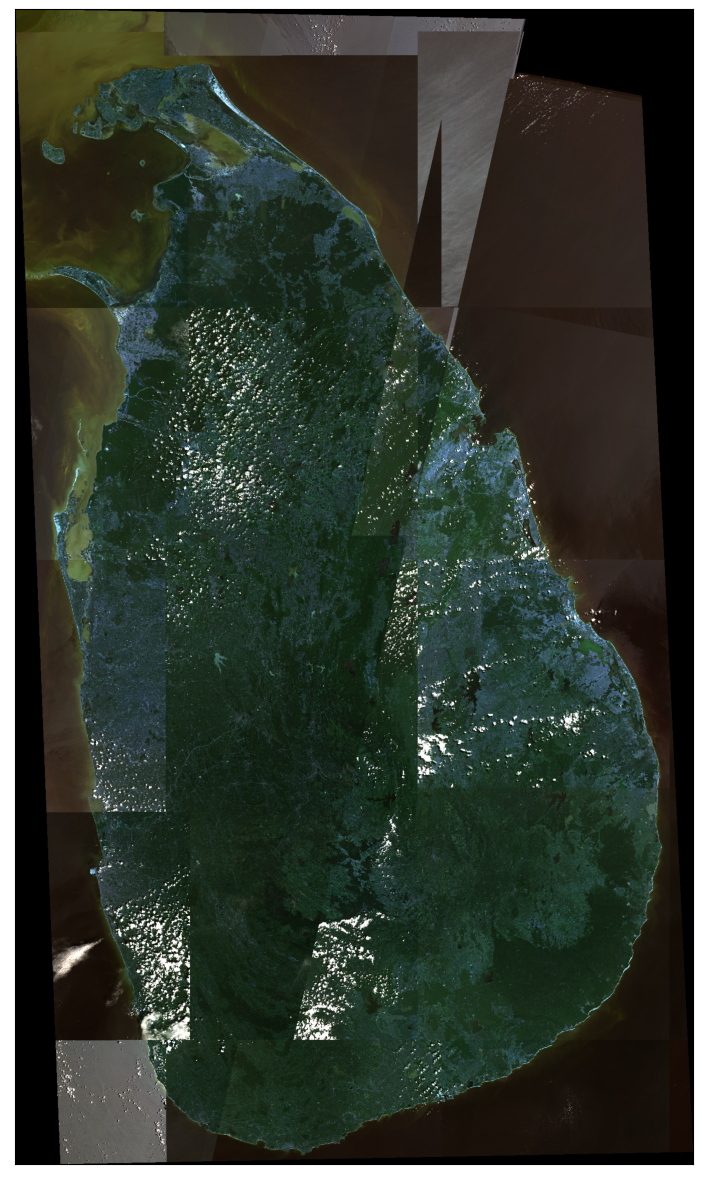

In [26]:
#visualize RGB
plot_image(all_bands_response[0][:, :, [0,1, 2]], factor=3.5 / 1e4, clip_range=(0, 1))

In [27]:
all_bands_img = request_all_bands.get_data(save_data=True)